In [4]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os 


In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [12]:
# function that would read an image provided the image path, preprocess and return it back
X_train = [] # To store train images
y_train = [] # To store train labels

# labels -
# 0 - Covid
# 1 - Normal

train_path = "./train/" # path containing training image samples
def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # reading the image
    img = cv2.resize(img, (256, 256)) # resizing it (I just like it to be powers of 2)
    img = np.array(img, dtype='float32') # convert its datatype so that it could be normalized
    img = img/255 # normalization (now every pixel is in the range of 0 and 1)
    return img

for folder in os.scandir(train_path):
    for entry in os.scandir(train_path + folder.name):

        X_train.append(read_and_preprocess(train_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_train.append(0)
        elif folder.name[0]=='N':
            y_train.append(1)

In [13]:
X_train = np.array(X_train)
X_train.shape # We have 251 training samples in total

(181, 256, 256, 3)

In [14]:
y_train = np.array(y_train)
y_train.shape

(181,)

covid= 111
normal= 70


<BarContainer object of 2 artists>

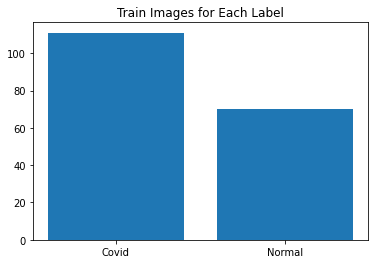

In [17]:
covid_count = len(y_train[y_train==0])
normal_count = len(y_train[y_train==1])
print('covid=' , covid_count)
print('normal=' , normal_count)
plt.title("Train Images for Each Label")
plt.bar(["Covid", "Normal"],[covid_count, normal_count])

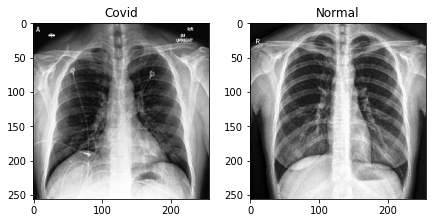

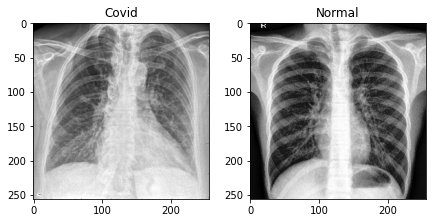

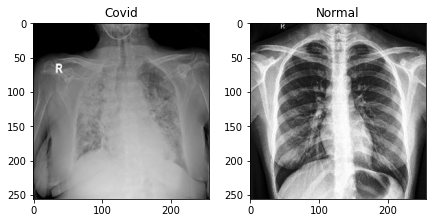

In [21]:

import random

title = {0:"Covid", 1:"Normal"}

rows = 3
columns = 3

for i in range(3):
    
    fig = plt.figure(figsize=(11,11))
    
    fig.add_subplot(rows, columns, 1)
    pos = random.randint(0, covid_count)
    plt.imshow(X_train[pos])
    plt.title(title[y_train[pos]])
    
    fig.add_subplot(rows, columns, 2)
    pos = random.randint(covid_count, covid_count+normal_count)
    plt.imshow(X_train[pos])
    plt.title(title[y_train[pos]])
    

In [34]:
#test image
X_test = []
y_test = []
test_path = "./test/"
for folder in os.scandir(test_path):
    for entry in os.scandir(test_path + folder.name):

        X_test.append(read_and_preprocess(test_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_test.append(0)
        elif folder.name[0]=='N':
            y_test.append(1)

In [35]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [36]:
X_test.shape

(46, 256, 256, 3)

In [37]:
y_test.shape

(46,)

In [46]:
def feature_extractor(data):
    x_train = data
    image_dataset = pd.DataFrame()
    for image in range(x_train.shape[0]):
        df = pd.DataFrame()
        input_img = x_train[image, :,:,:]
        img = input_img
        
        #feature 1 - pixel values
        pixel_values = img.reshape(-1)
        df['Pixel_Value'] = pixel_values   #Pixel value itself as a feature
        
        #feature 2 - gabor features
        num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
        kernels = []
        for theta in range(2):   #Define number of thetas
            theta = theta / 4. * np.pi
            for sigma in (1, 3):  #Sigma with 1 and 3
                lamda = np.pi/4
                gamma = 0.5
                gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
    #                print(gabor_label)
                ksize=9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)
                #Now filter the image and add values to a new column 
                fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                #print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                num += 1  #Increment for gabor column label
        
        image_dataset = image_dataset.append(df)
    
    return image_dataset



In [47]:
image_feat = feature_extractor(X_train)

In [54]:
n_features = image_feat.shape[1]
image_feat = np.expand_dims(image_feat, axis=0)
X_for_RF = np.reshape(image_feat, (X_train.shape[0], -1))

In [55]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF_model.fit(X_for_RF, y_train) 

RandomForestClassifier(n_estimators=50, random_state=42)

In [58]:
test_features = feature_extractor(X_test)
test_features = np.expand_dims(test_features, axis=0)
test_for_RF = np.reshape(test_features, (X_test.shape[0], -1))

test_prediction = RF_model.predict(test_for_RF)
#Inverse le transform to get original label back. 


In [63]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, test_prediction))

#Print confusion matrix
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test, test_prediction)

Accuracy =  0.9782608695652174


In [62]:
print(cm)

[[25  1]
 [ 0 20]]


In [65]:
print(classification_report(y_test,test_prediction))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.95      1.00      0.98        20

    accuracy                           0.98        46
   macro avg       0.98      0.98      0.98        46
weighted avg       0.98      0.98      0.98        46

